# Introduction to Tensorflow - A Deep Logistic Classifier

In Part 2 of the introduction to tensorflow notebooks a simple logistic classifier was built using TensorFlow. In this part, the logistic classifier is going to be extended by adding hidden layers making the neural network 'deep'.
Topics covered here:

  *  Addition of a hidden layer
  *  Use of RELU (Rectified Linear Units)
  *  Dropout as a regularisation technique


### Hidden Layer with ReLU activation function

ReLU or Rectified Linear Unit is a simple and effective activation function commonly used.
TensorFlow provides the ReLU function as `tf.nn.relu()`.

```python

hidden_layer = tf.add(tf.matmul(features, hidden_weights), hidden_biases)
hidden_layer = tf.nn.relu(hidden_layer)

output = tf.add(tf.matmul(hidden_layer, output_weights), output_biases)
```

The above code applies the `tf.nn.relu()` function to the hidden_layer, effectively turning off any negative weights and acting like an on/off switch. Adding additional layers, like the output layer, after an activation function turns the model into a nonlinear function. This nonlinearity allows the network to solve more complex problems.

### Dropout 

Dropout is a regularization technique for reducing overfitting. The technique temporarily drops units from the network, along with all of those units' incoming and outgoing connections. 

TensorFlow provides the `tf.nn.dropout()` function, which you can use to implement dropout.

```python
keep_prob = tf.placeholder(tf.float32) # probability to keep units

hidden_layer = tf.add(tf.matmul(features, weights[0]), biases[0])
hidden_layer = tf.nn.relu(hidden_layer)
hidden_layer = tf.nn.dropout(hidden_layer, keep_prob)

logits = tf.add(tf.matmul(hidden_layer, weights[1]), biases[1])

```

The `tf.nn.dropout()` function takes in two parameters:

* `hidden_layer`: the tensor to which you would like to apply dropout
* `keep_prob`: the probability of keeping (i.e. not dropping) any given unit

`keep_prob` allows you to adjust the number of units to drop. In order to compensate for dropped units, `tf.nn.dropout()` multiplies all units that are kept (i.e. not dropped) by $1/\mbox{keep_prob}$.

During training, a good starting value for keep_prob is 0.5.

During testing, use a keep_prob value of 1.0 to keep all units and maximize the power of the model.

### Load Modules and MNIST data 

In [1]:
%matplotlib inline
import tensorflow as tf
import math
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt


from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets(".", one_hot=True, reshape=False)

Extracting ./train-images-idx3-ubyte.gz
Extracting ./train-labels-idx1-ubyte.gz
Extracting ./t10k-images-idx3-ubyte.gz
Extracting ./t10k-labels-idx1-ubyte.gz


In [6]:
train_features = mnist.train.images
train_labels = mnist.train.labels
valid_features = mnist.validation.images
valid_labels = mnist.validation.labels
test_features = mnist.test.images
test_labels = mnist.test.labels

In [25]:
# Parameters
learning_rate = 0.01
batch_size = 128  # Decrease batch size if you don't have enough memory
epochs = 10
n_hidden_layer = 128 # layer number of features

# Dropout 
keep_prob = tf.placeholder(tf.float32)

n_input = 784  # MNIST data input (img shape: 28*28)
n_classes = 10  # MNIST total classes (0-9 digits)


# Store layers weight & bias
weights = {
    'hidden_layer': tf.Variable(tf.random_normal([n_input, n_hidden_layer]), name='hidden_layer_1_weights'),
    'out': tf.Variable(tf.random_normal([n_hidden_layer, n_classes]), name='output_layer_weights')
}
biases = {
    'hidden_layer': tf.Variable(tf.random_normal([n_hidden_layer]), name='hidden_layer_1_bias'),
    'out': tf.Variable(tf.random_normal([n_classes]), name='output_layer_bias')
}

# tf Graph input
features_original = tf.placeholder(tf.float32, [None, 28, 28, 1])
features = tf.reshape(features_original, [-1, n_input])
labels = tf.placeholder(tf.float32, [None, n_classes])

# Feed dicts for training, validation, and test session
train_feed_dict = {features_original: train_features, labels: train_labels, keep_prob: 0.5}
valid_feed_dict = {features_original: valid_features, labels: valid_labels, keep_prob: 1.0}
test_feed_dict = {features_original: test_features, labels: test_labels, keep_prob: 1.0}

# Hidden layer with RELU activation
hidden_layer_1 = tf.add(tf.matmul(features, weights['hidden_layer']), biases['hidden_layer'])
hidden_layer_1 = tf.nn.relu(hidden_layer_1)
hidden_layer_1 = tf.nn.dropout(hidden_layer_1, keep_prob)

# Output layer with linear activation
logits = tf.matmul(hidden_layer_1, weights['out']) + biases['out']
prediction = tf.nn.softmax(logits)

# Define loss and optimizer
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

# Initializing the variables
init = tf.global_variables_initializer()

# Determine if the predictions are correct
is_correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(labels, 1))

# Calculate the accuracy of the predictions
accuracy = tf.reduce_mean(tf.cast(is_correct_prediction, tf.float32))   

Epoch 10/10: 100%|██████████| 430/430 [00:06<00:00, 67.76batches/s]


Trained Model Saved.


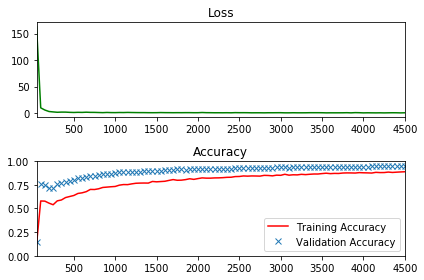

Validation accuracy at 0.944599986076355


In [26]:
# The accuracy measured against the validation set
validation_accuracy = 0.0

# Measurements use for graphing loss and accuracy
log_batch_step = 50
batches = []
loss_batch = []
train_acc_batch = []
valid_acc_batch = []

save_file = './train_deep_model.ckpt'
saver = tf.train.Saver()

with tf.Session() as session:
    session.run(init)
    batch_count = int(math.ceil(len(train_features)/batch_size))
    
    for epoch_i in range(epochs):
        #np.random.seed(epoch_i); np.random.shuffle(train_features)
        #np.random.seed(epoch_i); np.random.shuffle(train_labels)
        
        # Progress bar
        batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(epoch_i+1, epochs), unit='batches')
        
        # The training cycle
        for batch_i in batches_pbar:
            # Get a batch of training features and labels
            batch_start = batch_i*batch_size
            batch_features = train_features[batch_start:batch_start + batch_size]
            batch_labels = train_labels[batch_start:batch_start + batch_size]

            # Run optimizer and get loss
            _, l = session.run([optimizer, loss],
                               feed_dict={features_original: batch_features, 
                                          labels: batch_labels,
                                          keep_prob: 0.5
                                         })

            # Log every 50 batches
            if not batch_i % log_batch_step:
                # Calculate Training and Validation accuracy
                training_accuracy = session.run(accuracy, feed_dict=train_feed_dict)
                validation_accuracy = session.run(accuracy, feed_dict=valid_feed_dict)

                # Log batches
                previous_batch = batches[-1] if batches else 0
                batches.append(log_batch_step + previous_batch)
                loss_batch.append(l)
                train_acc_batch.append(training_accuracy)
                valid_acc_batch.append(validation_accuracy)

        # Check accuracy against Validation data
        validation_accuracy = session.run(accuracy, feed_dict=valid_feed_dict)
    
    # Save the model
    saver.save(session, save_file)
    print('Trained Model Saved.')

loss_plot = plt.subplot(211)
loss_plot.set_title('Loss')
loss_plot.plot(batches, loss_batch, 'g')
loss_plot.set_xlim([batches[0], batches[-1]])
acc_plot = plt.subplot(212)
acc_plot.set_title('Accuracy')
acc_plot.plot(batches, train_acc_batch, 'r', label='Training Accuracy')
acc_plot.plot(batches, valid_acc_batch, 'x', label='Validation Accuracy')
acc_plot.set_ylim([0, 1.0])
acc_plot.set_xlim([batches[0], batches[-1]])
acc_plot.legend(loc=4)
plt.tight_layout()
plt.show()

print('Validation accuracy at {}'.format(validation_accuracy))

### Test the model against your hold out dataset/testing data.

In [27]:
# The accuracy measured against the test set
test_accuracy = 0.0

# Restore location
saver = tf.train.Saver()

with tf.Session() as session:
    
    # Restore model from file
    saver.restore(session, save_file)
    
    # Check accuracy against Test data
    test_accuracy = session.run(accuracy, feed_dict=test_feed_dict)
    print(test_accuracy)

0.9435
